# Thinking about fair APRs for profit and fun
This is a short introduction to finding fair APRs for zero-liquidation loans.

## Introduction
Recall that a zero-liquidation loan can be seen as a swap, where the borrower pledges collateral and receives a loan amount plus an embedded call option. For example, let's assume you pledge 1 ETH worth `$1,500` and you can borrow `$700` against it for 30 days. Now to make the swap fair you should receive a call option which is worth `$800` because this way your position value pre- and post borrow is the same, i.e., nobody is better or worse off than before. Now the question is:

> How should we choose the strike price of the call option such its fair value is `$800`?

## Option Pricing
The most simple way to price a call option is to use Black-Scholes. While for our case the Black-Scholes model is a crude over-simplification it nonetheless is a good way to start thinking about how to determine a fair APR.

So, for a European call option we can apply the following Black-Scholes formula:

$C(S,t) = S \Phi(d_1) - K e^{-r(T-t)} \Phi(d_2)$

where

$d1 = \frac{ln(S/K) + (r+\sigma^2/2)(T-t)}{\sigma \sqrt{T-t}}$

$d_2 = d_1 - \sigma \sqrt{T-t}$

and

* $S$: current price of the collateral
* $r$: risk free rate
* $\sigma$: price volatility of the collateral 
* $T-t$: tenor of the option
* $K$: strike price

Let's put that into code:

In [1]:
import numpy as np
from scipy.stats import norm
from scipy import optimize

def getD1(S, K, sigma, optionTenorInYears, r):
    return (np.log(S / K) + (r + sigma**2 / 2) * optionTenorInYears) / \
        (sigma * np.sqrt(optionTenorInYears))

def getCallValue(
        spotPrice,
        strikePrice,
        sigma,
        optionTenorInYears,
        riskFreeRate):
    if optionTenorInYears <= 0:
        return max([0, spotPrice - strikePrice])
    if strikePrice <= 0:
        return spotPrice
    d1 = getD1(spotPrice, strikePrice, sigma, optionTenorInYears, riskFreeRate)
    d2 = d1 - sigma * np.sqrt(optionTenorInYears)
    return spotPrice * norm.cdf(d1) - strikePrice * \
        np.exp(-riskFreeRate * optionTenorInYears) * norm.cdf(d2)

### Example: pricing a call
So let's assume the ETH price is $\$1500$ and we want to buy a European call option with strike price $K=\$702$, a tenor of $T-t=30./365.$ years, and with ETH vol being at $\sigma=100\%$ and the risk free rate at $r=2\%$. 

Using the Black-Scholes model, what would be the fair price of such an option? Let's use our `getCallValue` function above:

In [2]:
S = 1500
K = 702
sigma = 1.
tenor = 30./365.
r = .02
callValue = getCallValue(S, K, sigma, tenor, r)
print("call value is:", callValue)

call value is: 799.5115640645636


### Example: thinking about the fairness of the swap and implied APR
So we can see that the value of such a call option should be around $\approx \$800$. So if we were to swap 1 ETH ($=\$1500$) to received a loan of $\$700$ as well as this call option worth $\$800$ then we wouldn't be better or worse off, i.e., this swap would be fair.

Let's think about what that means in terms of APR. Let $L=\$700$ denote your loan amount. Now if you end up repaying the strike price $K=\$702$ to reclaim your collateral prior to expiry of the loan, i.e., within $\Delta T=30/365 \; years$ then on an annualized basis your percentage interest cost would be $APR = \Big(\frac{K}{L}-1\Big) \cdot \frac{1}{\Delta T}$, or continuing our code example:

In [3]:
L = 700.
K = 702.
dT = 30./365
APR = (K/L-1)/dT
print("APR is:", APR)

APR is: 0.03476190476190518


So this means that the implied fair APR would be $3.5\%$.

### Finding fair strike price = minimization problem
In the previous example we were lucky because our initial guess for the strike price turned out to result in a option price that indeed made the swap fair for the given loan amount. But what if we wanted to find such a strike price for any kind of loan amount?

Basically, given the current spot price $S$ and loan amount $L$ we're interested in finding $K^*$ such that the following equation holds:

$S = L + C(K^*)$

We can translate this into the following minimization problem:

$K^* = \arg \min_{K} \Big(S - L - C(K)\Big)^2$

and use scipy's optimization library for this:

In [4]:
def getEquilibriumCallStrike(
        CTokenIn,
        fees,
        BTokenOut,
        spotPrice,
        sigma,
        optionTenorInYears,
        riskFreeRate):
    def minFunc(
            strikePrice,
            fees,
            CTokenIn,
            BTokenOut,
            spotPrice,
            sigma,
            optionTenorInYears,
            riskFreeRate):
        callValue = getCallValue(
            spotPrice,
            strikePrice,
            sigma,
            optionTenorInYears,
            riskFreeRate)
        return (callValue * CTokenIn * (1 - fees) +
                BTokenOut - CTokenIn * spotPrice)**2
    args = (
        fees,
        CTokenIn,
        BTokenOut,
        spotPrice,
        sigma,
        optionTenorInYears,
        riskFreeRate)
    initialStrikeGuess = spotPrice
    strikeBounds = (0.1, None)
    res = optimize.minimize(
        minFunc,
        args=args,
        x0=[initialStrikeGuess],
        bounds=[strikeBounds])
    return res['x'][0]

For example, let's assume we wanted to have a higher loan amount of $L=\$ 1000$, then the corresponding fair strike price can be found by using our previously defined `getEquilibriumCallStrike` function, i.e.:

In [5]:
CTokenIn = 1
fees = 0
BTokenOut = 1000
spotPrice = 1500
sigma = 1.
optionTenorInYears = 30./365.
riskFreeRate = .02
fairK = getEquilibriumCallStrike(
    CTokenIn,
    fees,
    BTokenOut,
    spotPrice,
    sigma,
    optionTenorInYears,
    riskFreeRate)
impliedAPR = (fairK/BTokenOut-1)/optionTenorInYears

print("the fair strike K is:", fairK)
print("the implied APR is:", impliedAPR)

the fair strike K is: 1015.5245698262931
the implied APR is: 0.18888226621989979


So we can see that the fair strike $K^* = \$ 1015.5$ as well as the implied $APR = 19 \%$ are now higher then in the previous example. Intuitively, this also makes sense because the LTV of the loan is now higher, which means that LPs bear more risk and hence expect to receive a higher APR to be compensated for this.

Similarly, we would expect that the fair APR should increase for longer tenors, but let's verify. For this we can create a heatmap to quickly get a sense of how the APR changes across different LTV and tenor combinations:

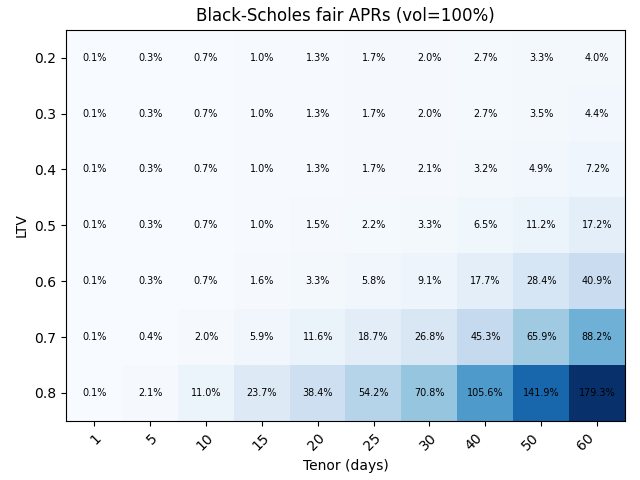

In [6]:
import matplotlib.pyplot as plt

CTokenIn = 1
fees = 0
spotPrice = 1500
sigma = 1.
riskFreeRate = .02

ltvs = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
BTokenOuts = ltvs * spotPrice
tenorsInDays = np.array([1, 5, 10, 15, 20, 25, 30, 40, 50, 60])

plotData = []
for BTokenOut in BTokenOuts:
    tmp = []
    for tenor in tenorsInDays:
        fairK = getEquilibriumCallStrike(
            CTokenIn,
            fees,
            BTokenOut,
            spotPrice,
            sigma,
            tenor/365.,
            riskFreeRate)
        impliedAPR = (fairK/BTokenOut-1)/optionTenorInYears
        tmp.append(impliedAPR)
    plotData.append(tmp)
fig, ax = plt.subplots()
im = ax.imshow(plotData, cmap="Blues")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(ltvs)):
    for j in range(len(tenorsInDays)):
        text = ax.text(j, i, str(round(100*plotData[i][j],1)) + "%",
                       ha="center", va="center", color="black", size="x-small")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(tenorsInDays)), labels=tenorsInDays)
ax.set_yticks(np.arange(len(ltvs)), labels=ltvs)
ax.set_xlabel('Tenor (days)')
ax.set_ylabel('LTV')

ax.set_title("Black-Scholes fair APRs (vol=100%)")
fig.tight_layout()
plt.show()

And indeed can see that the Black-Scholes derived fair APRs increase for higher LTVs and longer tenors. We can also rerun the heatmap with $\sigma=150\%$ to see how a higher volatility level affects fair APRs:

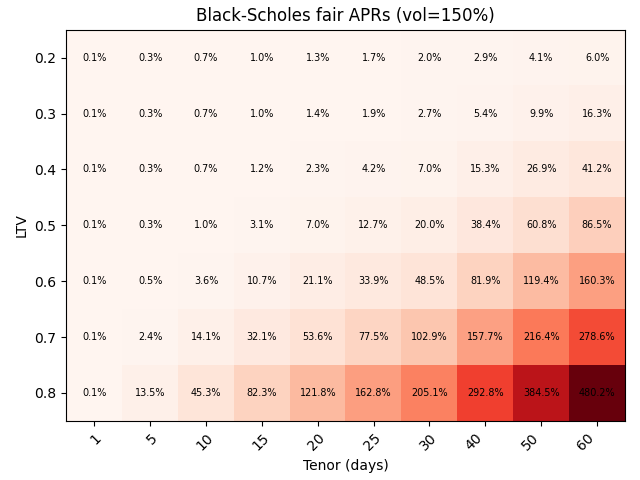

In [7]:
import matplotlib.pyplot as plt

CTokenIn = 1
fees = 0
spotPrice = 1500
sigma = 1.5
riskFreeRate = .02

ltvs = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
BTokenOuts = ltvs * spotPrice
tenorsInDays = np.array([1, 5, 10, 15, 20, 25, 30, 40, 50, 60])

plotData = []
for BTokenOut in BTokenOuts:
    tmp = []
    for tenor in tenorsInDays:
        fairK = getEquilibriumCallStrike(
            CTokenIn,
            fees,
            BTokenOut,
            spotPrice,
            sigma,
            tenor/365.,
            riskFreeRate)
        impliedAPR = (fairK/BTokenOut-1)/optionTenorInYears
        tmp.append(impliedAPR)
    plotData.append(tmp)
fig, ax = plt.subplots()
im = ax.imshow(plotData, cmap="Reds")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(ltvs)):
    for j in range(len(tenorsInDays)):
        text = ax.text(j, i, str(round(100*plotData[i][j],1)) + "%",
                       ha="center", va="center", color="black", size="x-small")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(tenorsInDays)), labels=tenorsInDays)
ax.set_yticks(np.arange(len(ltvs)), labels=ltvs)
ax.set_xlabel('Tenor (days)')
ax.set_ylabel('LTV')

ax.set_title("Black-Scholes fair APRs (vol=150%)")
fig.tight_layout()
plt.show()

As expected, we can see that a higher volatility level generally leads to higher APRs as well as a more pronounced differences between the individual LTV-vs-tenor APR combinations. Lastly, for a given tenor of e.g. 14 days we can also plot fair APRs across different LTV and volatility scenarios.

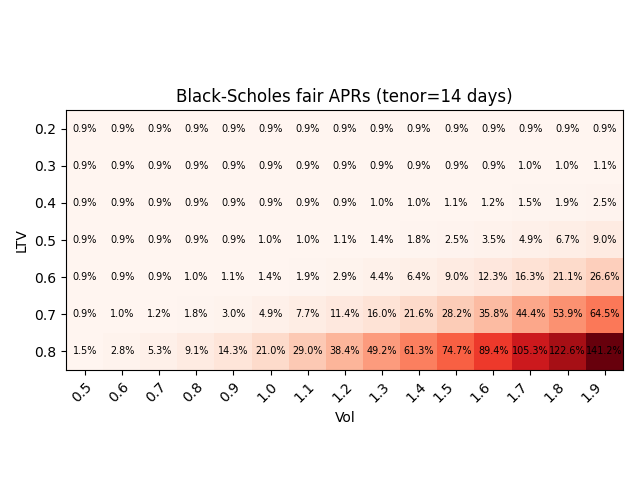

In [17]:
import matplotlib.pyplot as plt

CTokenIn = 1
fees = 0
spotPrice = 1500
tenor = 14./365
riskFreeRate = .02

ltvs = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
BTokenOuts = ltvs * spotPrice
vols = np.arange(.5,2.,.1)

plotData = []
for BTokenOut in BTokenOuts:
    tmp = []
    for vol in vols:
        fairK = getEquilibriumCallStrike(
            CTokenIn,
            fees,
            BTokenOut,
            spotPrice,
            vol,
            tenor,
            riskFreeRate)
        impliedAPR = (fairK/BTokenOut-1)/optionTenorInYears
        tmp.append(impliedAPR)
    plotData.append(tmp)
fig, ax = plt.subplots()
im = ax.imshow(plotData, cmap="Reds")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(ltvs)):
    for j in range(len(vols)):
        text = ax.text(j, i, str(round(100*plotData[i][j],1)) + "%",
                       ha="center", va="center", color="black", size="x-small")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(vols)), labels=np.round(vols, 2))
ax.set_yticks(np.arange(len(ltvs)), labels=ltvs)
ax.set_xlabel('Vol')
ax.set_ylabel('LTV')

ax.set_title("Black-Scholes fair APRs (tenor=14 days)")
fig.tight_layout()
plt.show()